# DTSA-5511 Week 4: NLP With Disaster Tweets
Author: Alan Klein

Create Date: 2025-07-17

github link: https://github.com/Saganoky/DTSA_5511_NLP_With_Disaster_Tweets

## Introduction

Twitter or other social media can be used to help identify when disasters occur.  However, one of the issues with doing this is understanding which tweets actually identify disasters.  For example, people use words such as ablaze metaphorically instead of using them to literally mean something is on fire.  This project will use RNN technics to help distinguish tweets announcing disasters from those that don't.


## Setup
The code below imports all the required packages.  This repo uses UV for package management, see https://docs.astral.sh/uv/ for more information.  If you are not familiar with UV I highly recommend you check it out. It fast and easy to use. Additionally, it is being used more and more in industry.

Ended up using the nightly update version of pytorch to support CUDA 12.9 installed using the following command

```uv pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu129```

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-07-19 16:13:48.136988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752959628.153480   17394 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752959628.158879   17394 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752959628.173180   17394 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752959628.173205   17394 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752959628.173207   17394 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# We'll be using Pytorch's text library called torchtext! 
from tqdm.notebook import trange, tqdm

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

2025-07-19 16:56:09.230216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752962169.239961   18246 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752962169.243192   18246 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752962169.251933   18246 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752962169.251943   18246 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752962169.251944   18246 computation_placer.cc:177] computation placer alr

In [7]:
# This sets up the kaggle API.  You need to have a kaggle account and a token to be able to run this code.  
# This video gives a pretty good explanation of how to get the token: https://www.youtube.com/watch?v=gkEbaMgvLs8&t=188s
api = KaggleApi()
api.authenticate()


In [ ]:
# Run these two commands to download and unzip the data sets into the data folder.
# !kaggle competitions download -c nlp-getting-started
# !unzip nlp-getting-started.zip -d data/

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  nlp-getting-started.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


## Exploratory Data Analysis

In [12]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [13]:
train.info

<bound method DataFrame.info of          id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...

In [14]:
# Look at the data
train.info()
test.info()

# Training data consists of 7613 records with 5 columns, id, keyword, location, text, and target.  
# Testing data consists of 3263 records to predict. 
# Sample_submission consists of 3263 records with id and target columns.
# Per the kaggle website the columns are defined as follows:
# id - a unique identifier for each tweet
# text - the text of the tweet
# location - the location the tweet was sent from (may be blank)
# keyword - a particular keyword from the tweet (may be blank)
# target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


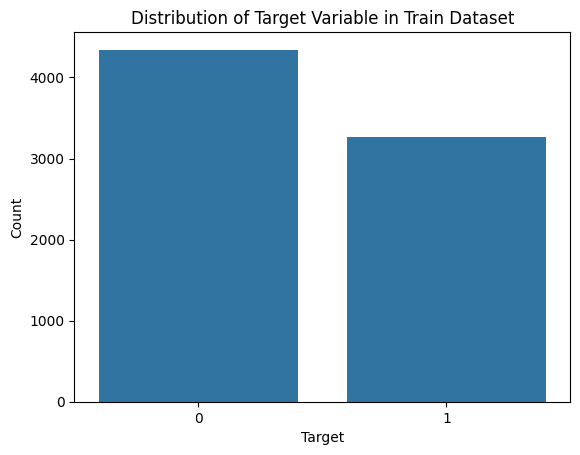

In [15]:
# Visualize the distribution of the target variable in the training dataset
sns.countplot(x='target', data=train)
plt.title('Distribution of Target Variable in Train Dataset')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Target variable is pretty balanced.

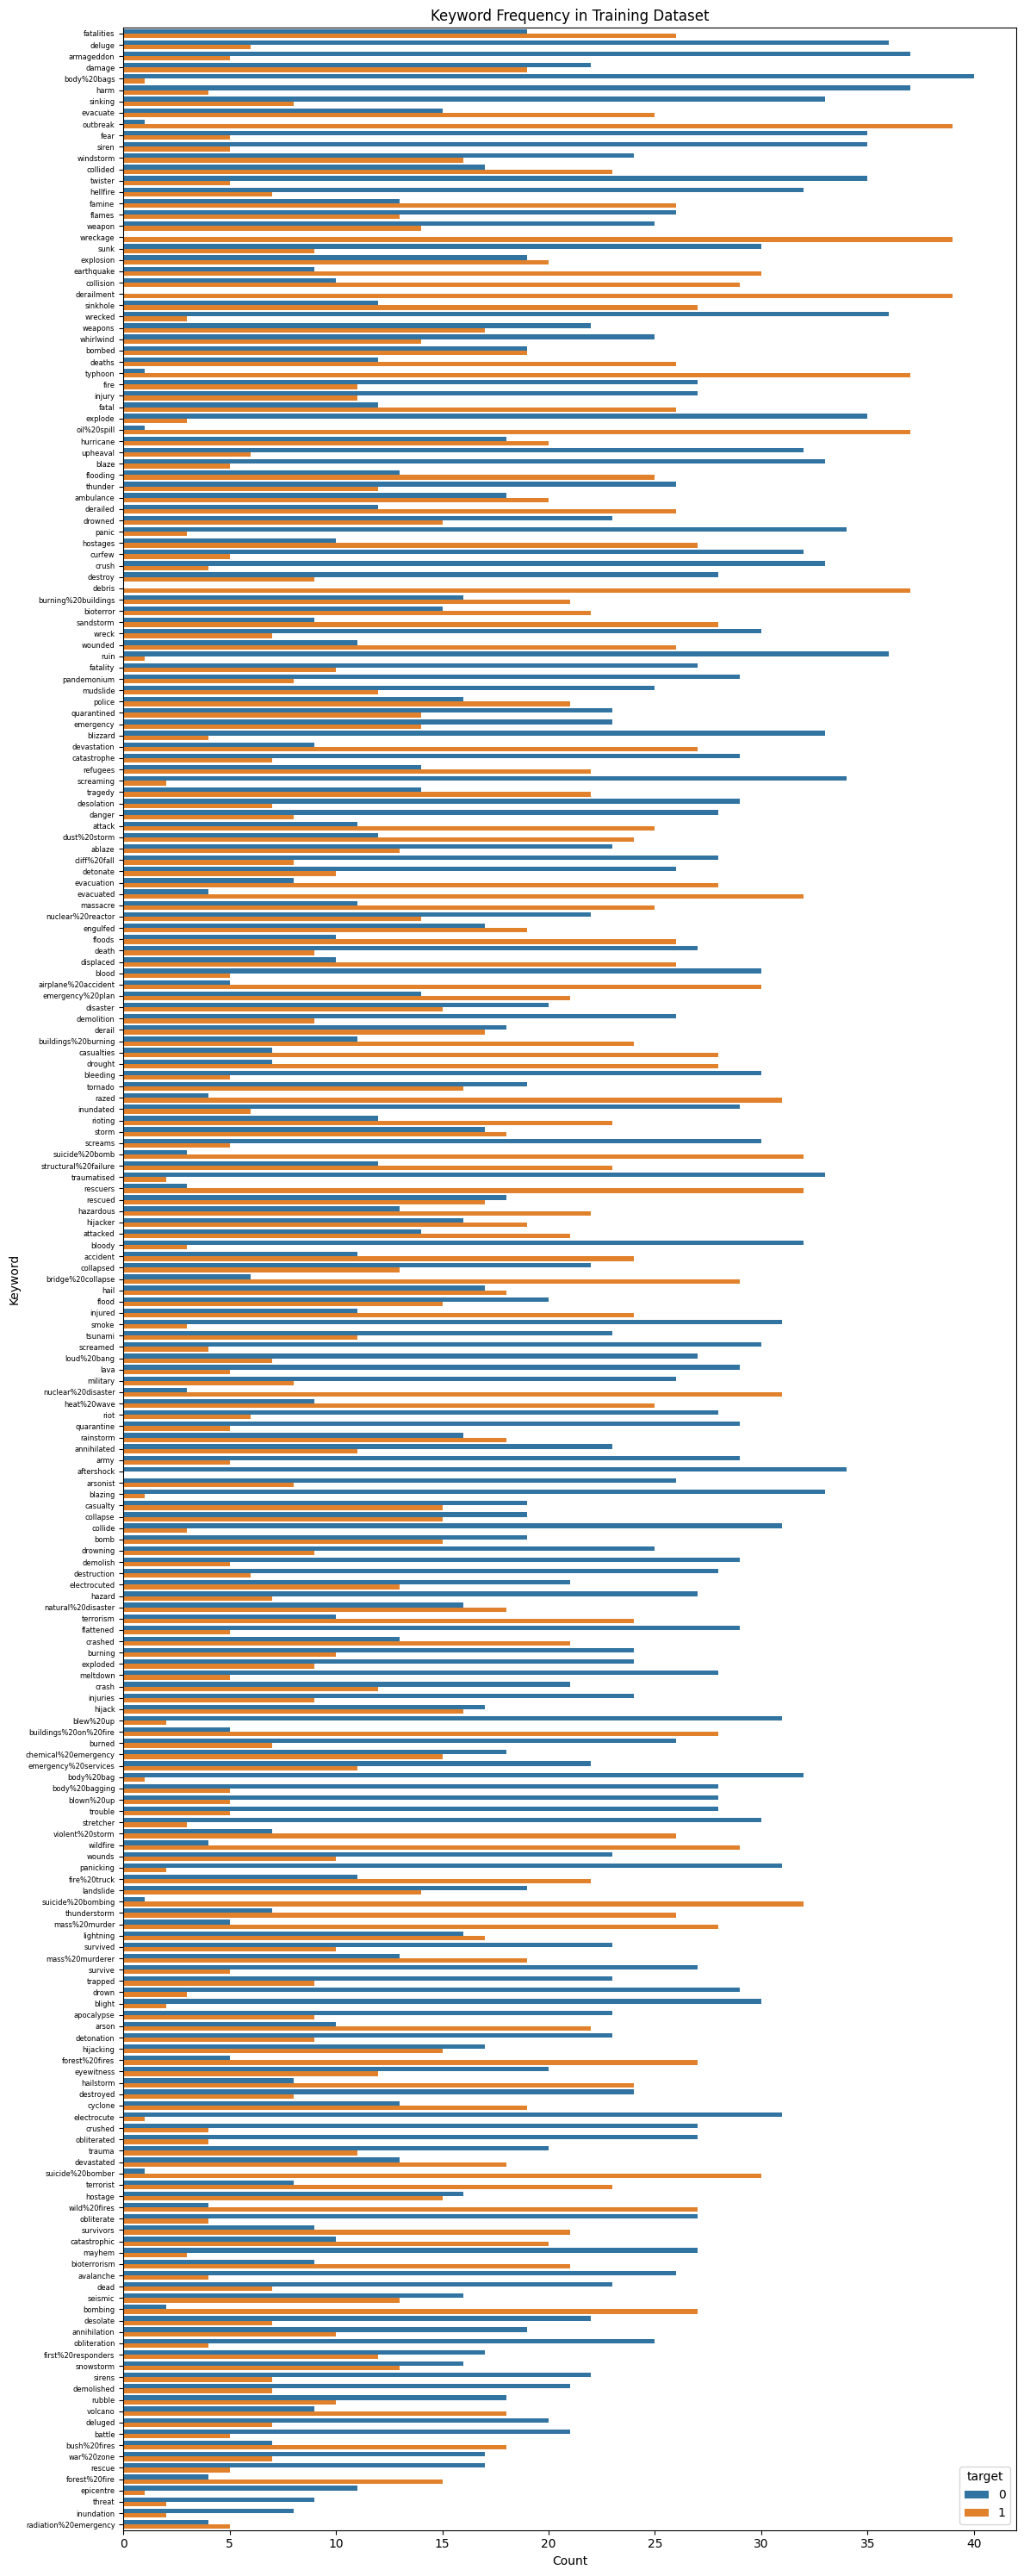

In [16]:
# Look at keyword frequency in the training dataset
plt.figure(figsize=(12, 30)) 
sns.countplot(y=train['keyword'], hue = train['target'], order=train['keyword'].value_counts().index)
plt.yticks(fontsize=6)  # Smaller font size for more labels
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.title('Keyword Frequency in Training Dataset')
plt.tight_layout()
plt.show()

# Some keywords don't have both a 0 and 1 target value.  This could lead to some bias, I'm going to drop the keyword column.

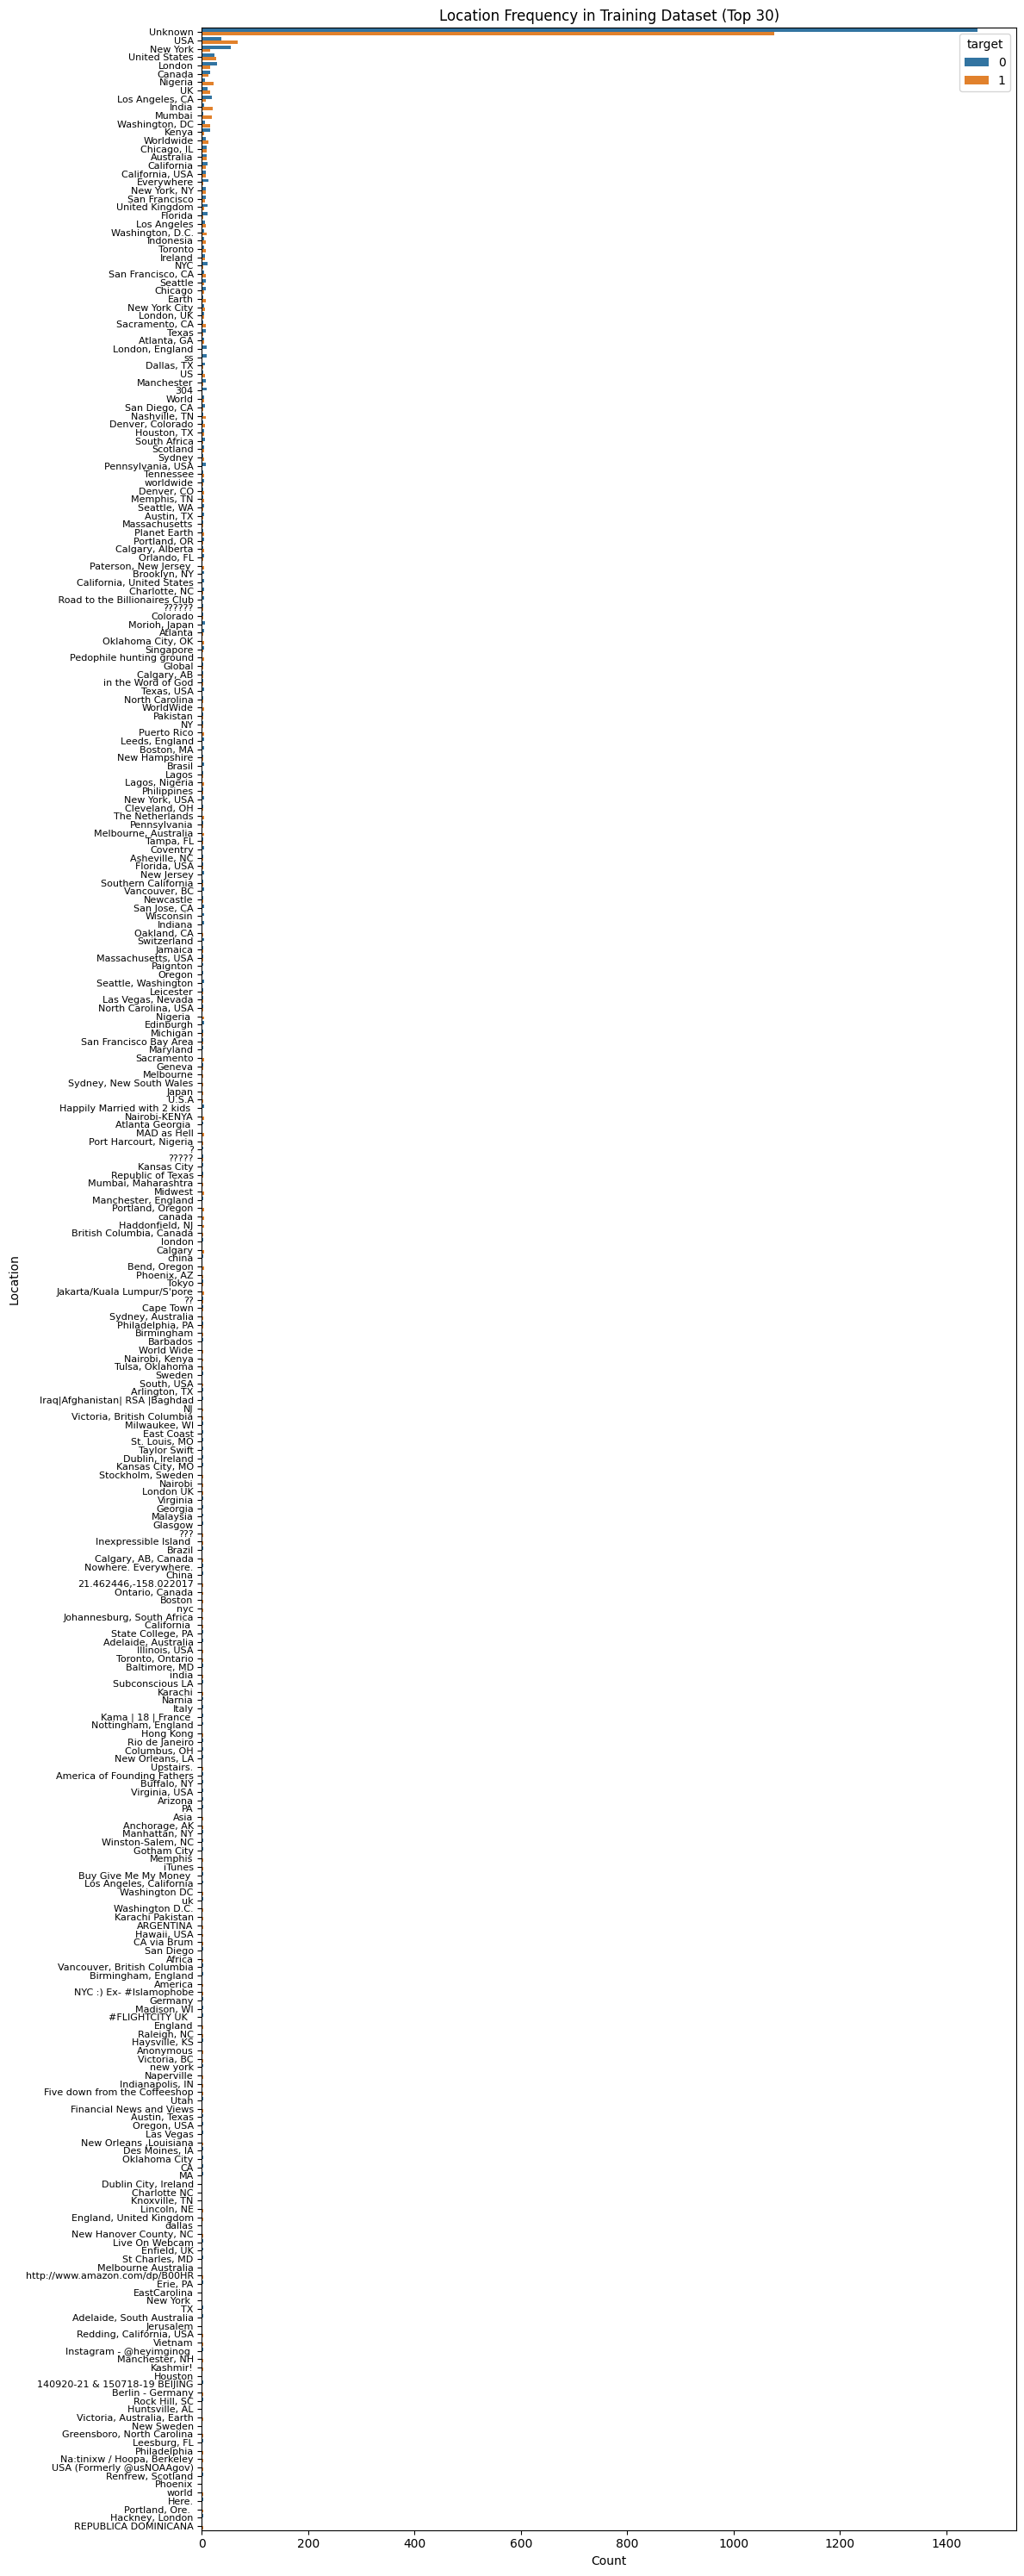

In [13]:
# Look at location frequency in the training dataset
# Fill NaN values in 'location' with 'Unknown'
train['location'] = train['location'].fillna('Unknown')

# Limit to top 30 most frequent locations for readability
top_locations = train['location'].value_counts().index[:300]

plt.figure(figsize=(12, 30))
sns.countplot(
	y=train[train['location'].isin(top_locations)]['location'],
	hue=train[train['location'].isin(top_locations)]['target'],
	order=top_locations
)
plt.yticks(fontsize=8)  # Smaller font size for more labels
plt.xlabel('Count')
plt.ylabel('Location')
plt.title('Location Frequency in Training Dataset (Top 30)')
plt.tight_layout()
plt.show()

# Many locations without both a 1 and 0.  Also, alot of unknowns.  For simplicity in this analysis, I'm going to drop the location column as well.

#

In [17]:
# Split the data into train and validation sets. 

X_train, X_val, y_train, y_val = train_test_split(train['text'], train['target'], test_size=0.2, random_state=1337)

X_train.head()


3554    The famine is coming to an end #Bluebell http:...
4542    Udhampur terror attack: Militants attack polic...
561     Do Your Own Thing: The Battle of Internal vs E...
4672    Punjab government flood relief platform: http:...
1270    when you're taking a shower and someone flushe...
Name: text, dtype: object

# Model
The following code is based on the TensorFlow documentation example.  See reference[1] for more information.

For this model I'll use a batch size of 64 and a buffer size of 1000.

For the model itself Ill use a single LSTM layer followed by a dense neural net layer with 64 neurons and one with a single neuron for binary classification.

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

In [25]:
# Convert training and validation data to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [26]:
# use the keras text encoder limit to 1000 words
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

2025-07-19 17:09:36.235114: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
# Top 20 words in the vocabulary, nothing suprising, we can see 
# that the most common words are stop words like 'the', 'and', 'to', etc.
# If this wasn't a weekly assignment, I would probably use a more sophisticated 
# tokenizer and remove stop words.
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is', 'for',
       'on', 'you', 'my', 'it', 'that', 'with', 'at', 'by', 'this'],
      dtype='<U17')

In [ ]:
# Define the model architecture
# We will use a simple LSTM model followed by a dense layer for binary classification.
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
# Define the loss, optimizer, and metrics for the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [37]:
# Train the model
history = model.fit(train_dataset, epochs=10,
                    validation_data=val_dataset,
                    validation_steps=30)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5630 - loss: 0.6901 - val_accuracy: 0.5640 - val_loss: 0.6825
Epoch 2/10
 8/96 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5261 - loss: 0.6849

/home/aklein01/dtsa5511/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5607 - loss: 0.6753 - val_accuracy: 0.5640 - val_loss: 0.6339
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5946 - loss: 0.6036 - val_accuracy: 0.7472 - val_loss: 0.5058
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7716 - loss: 0.4911 - val_accuracy: 0.7597 - val_loss: 0.4777
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7919 - loss: 0.4552 - val_accuracy: 0.7925 - val_loss: 0.4575
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8002 - loss: 0.4305 - val_accuracy: 0.8063 - val_loss: 0.4466
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8168 - loss: 0.4077 - val_accuracy: 0.8083 - val_loss: 0.4427
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8200 - loss: 0.3918 - val_accuracy: 0.8030 - val_loss: 0.4377
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8250 - loss: 0.3778 - val_accuracy: 0.8076 - val_loss: 0.

In [39]:
val_loss, val_acc = model.evaluate(val_dataset)

print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_acc)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8140 - loss: 0.4240
Validation Loss: 0.44065409898757935
Validation Accuracy: 0.8043335676193237


(0.0, 0.7020650342106819)

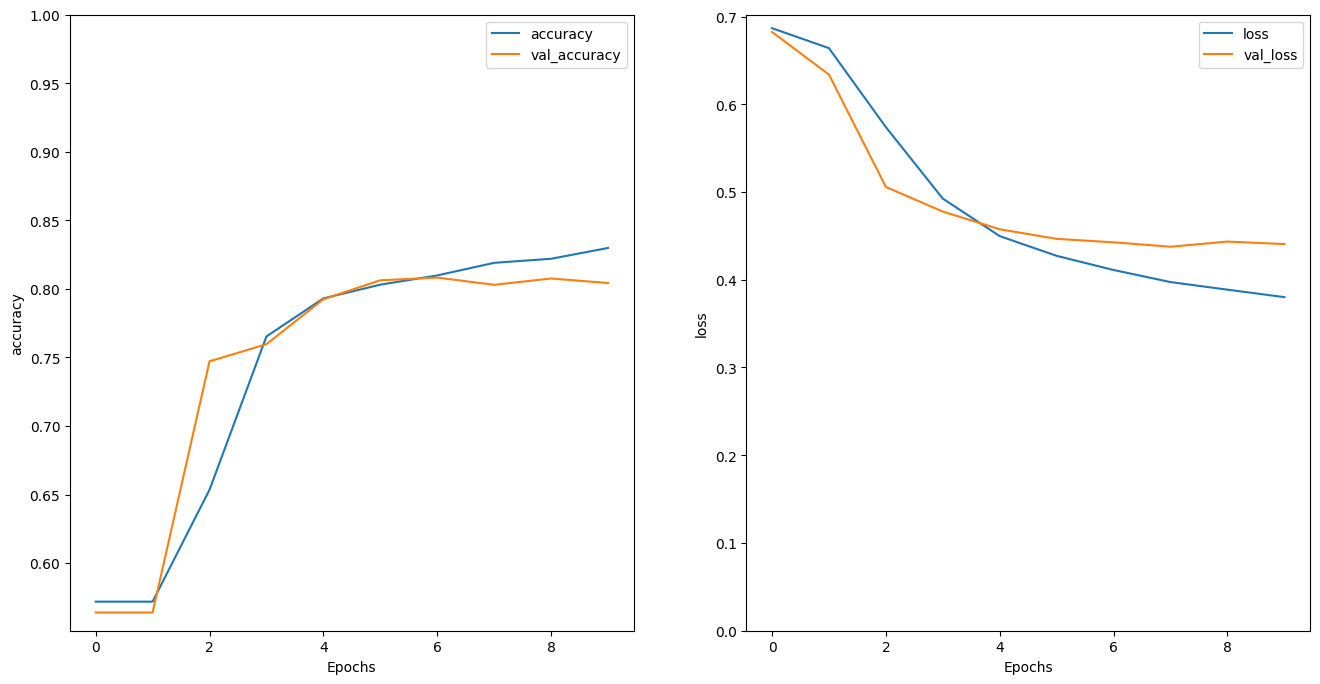

In [40]:
# Plot the training and validation accuracy and loss
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Validation accuracy and loss seem to level out meaning that we are training on enough epochs.

In [47]:
# Predict on the test dataset
test_texts = test['text'].values

test_predictions = model.predict(np.array(test_texts, dtype=object))
test_preds = (test_predictions >= 0).astype(int).flatten()

sample_submission['target'] = test_preds
sample_submission.to_csv('data/LSTM_submission_1.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
[[ 7.78227746e-01]
 [ 3.38180035e-01]
 [ 1.82300782e+00]
 [-4.31422800e-01]
 [ 2.64431000e+00]
 [ 1.45200443e+00]
 [-2.01943827e+00]
 [-1.22535086e+00]
 [-8.66607487e-01]
 [-3.82608891e-01]
 [-1.21116662e+00]
 [-9.72431242e-01]
 [-9.39794898e-01]
 [-4.07888532e-01]
 [-2.29586035e-01]
 [-1.73047912e+00]
 [-1.78770316e+00]
 [-3.92603278e-01]
 [-1.79534709e+00]
 [-2.25691342e+00]
 [-1.37091947e+00]
 [-9.30830061e-01]
 [-1.25633931e+00]
 [ 3.84723008e-01]
 [-1.35103226e+00]
 [-1.43175442e-02]
 [-1.43806815e+00]
 [ 7.08368480e-01]
 [-2.00026894e+00]
 [ 2.61163235e+00]
 [-1.20192301e+00]
 [ 1.11775780e+00]
 [ 6.62032366e-01]
 [ 2.18334243e-01]
 [ 2.74290037e+00]
 [-1.27724409e+00]
 [ 2.39420033e+00]
 [-1.13383338e-01]
 [-1.85651493e+00]
 [ 1.87172055e+00]
 [-2.71417475e+00]
 [ 2.90967989e+00]
 [ 5.86185157e-01]
 [ 4.81258124e-01]
 [-3.28095412e+00]
 [-2.58780646e+00]
 [-1.59403956e+00]
 [-2.51618552e+00]
 [-4.87434596e-01]
 [-2.51618552e+00]
 [-2.0559

In [50]:
# First submission to Kaggle
!kaggle competitions submit -c nlp-getting-started -f data/LSTM_submission_1.csv -m "simple LSTM model"

100%|██████████████████████████████████████| 22.2k/22.2k [00:00<00:00, 55.6kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

## Results Model 1
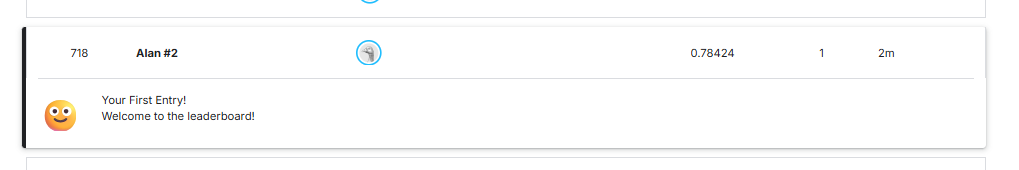

718! Not bad for a first entry with a simple model.  This model worked quite well considering how simple it was.  I was actually really suprised considering I didn't use the location or keywords.  Additionally, I didn't remove stop words.

# Model 2
The main difference of this model will be it will use a GRU instead of a LSTM.

In [52]:

gru_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [53]:
# Define the loss, optimizer, and metrics for the model
gru_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['Accuracy'])

In [54]:
# Train the model
gru_history = gru_model.fit(train_dataset, epochs=10,
                    validation_data=val_dataset,
                    validation_steps=30)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - Accuracy: 0.5697 - loss: 0.6896 - val_Accuracy: 0.5640 - val_loss: 0.6830
Epoch 2/10
 9/96 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - Accuracy: 0.6291 - loss: 0.6706

/home/aklein01/dtsa5511/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Accuracy: 0.5834 - loss: 0.6748 - val_Accuracy: 0.5640 - val_loss: 0.6624
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Accuracy: 0.5718 - loss: 0.6410 - val_Accuracy: 0.6802 - val_loss: 0.5592
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - Accuracy: 0.7235 - loss: 0.5390 - val_Accuracy: 0.7787 - val_loss: 0.4737
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Accuracy: 0.7884 - loss: 0.4600 - val_Accuracy: 0.7597 - val_loss: 0.4815
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Accuracy: 0.7994 - loss: 0.4300 - val_Accuracy: 0.7846 - val_loss: 0.4408
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Accuracy: 0.8227 - loss: 0.3959 - val_Accuracy: 0.8030 - val_loss: 0.4291
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Accuracy: 0.8234 - loss: 0.3862 - val_Accuracy: 0.8083 - val_loss: 0.4270
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - Accuracy: 0.8306 - loss: 0.3737 - val_Accuracy: 0.8109 - val_loss: 0.

In [55]:
gru_val_loss, gru_val_acc = gru_model.evaluate(val_dataset)

print('Validation Loss:', gru_val_loss)
print('Validation Accuracy:', gru_val_acc)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Accuracy: 0.8203 - loss: 0.4149
Validation Loss: 0.4290923476219177
Validation Accuracy: 0.8076165318489075


(0.0, 0.7027064844965935)

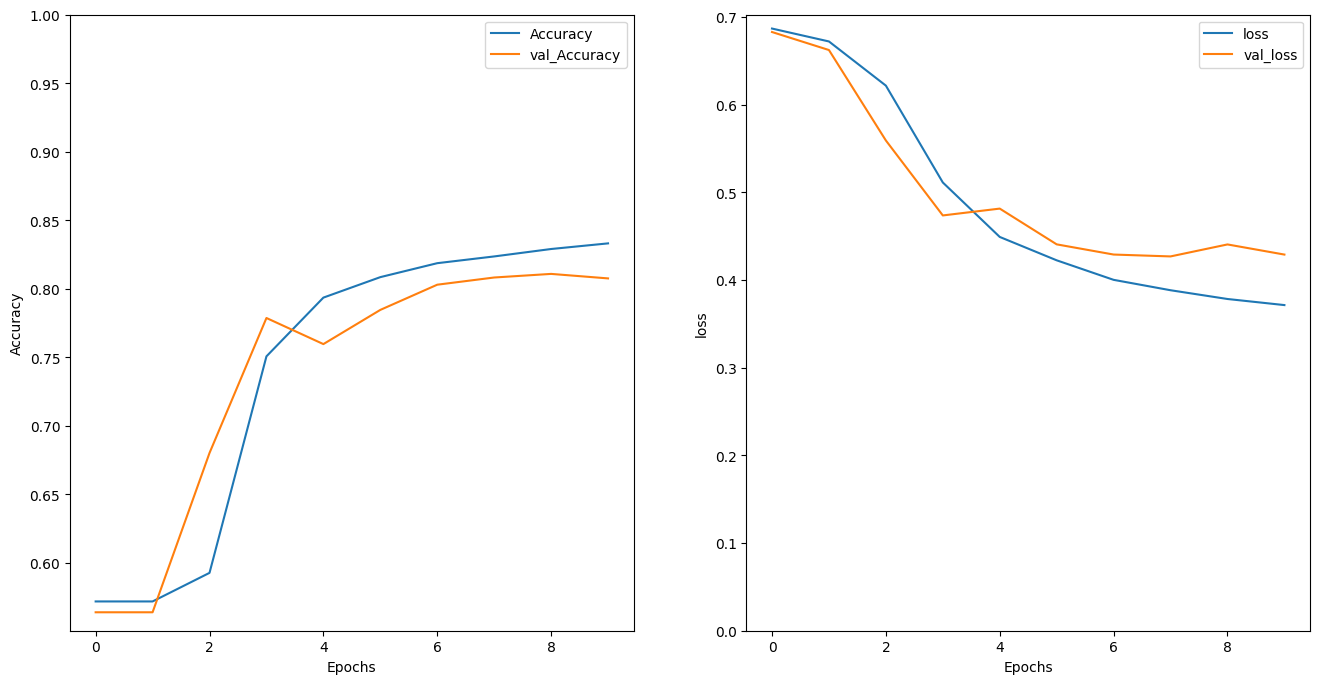

In [57]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(gru_history, 'Accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(gru_history, 'loss')
plt.ylim(0, None)

In [58]:
# Predict on the test dataset
test_texts = test['text'].values

test_predictions = model.predict(np.array(test_texts, dtype=object))
test_preds = (test_predictions >= 0).astype(int).flatten()

sample_submission['target'] = test_preds
sample_submission.to_csv('data/gru_submission_1.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [59]:
# Second submission to Kaggle
!kaggle competitions submit -c nlp-getting-started -f data/gru_submission_1.csv -m "simple gru model"

100%|██████████████████████████████████████| 22.2k/22.2k [00:00<00:00, 54.8kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

## Results GRU Model

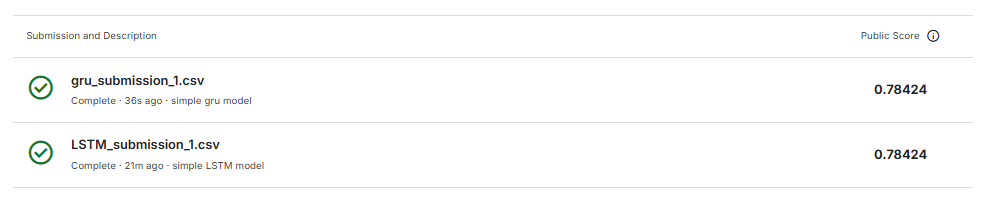

Well it performed pretty much exactly the same as the LSTM model.  This tells me that the choice of LSTM vs GRU doesn't matter much in this case and additional accuracy will come from either hyperparameter tuning.  A more complex model or additional data prep.

## Conclusion

Overall both models were a success.  There are definately gains to be made in predictive power.  The next step to improve the mdoel would be to figure out how to either clean the data or use the keyword and location data.

## References
[1] https://www.tensorflow.org/text/tutorials/text_classification_rnn